**Christian Steinmetz**

Due on October 30th

In this task we will focus on a training set only. Consider the datasets in:
http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/


In [252]:
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.utils import resample

mpl.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format = 'retina'

## Dataset
For both the regression and classification task we use data from the [Spotify Audio Features dataset](https://www.kaggle.com/tomigelo/spotify-audio-features) which provides pre-computed audio features for 130k tracks collected from the official Spotify Web API. In the regression task we use these features to attempt to predict the populaity of each track, which is a scalar value from 0-100. In order to turn this task into classification task, we generate a new binary label for each track, where a track is considered 'popualar' if it has a populaity rating larger than or equal to 50, and 'unpopular' if the populaity rating is less than 50.

In [233]:
april2019 = pd.read_csv('p1_data/SpotifyAudioFeaturesApril2019.csv') 
nov2018 = pd.read_csv('p1_data/SpotifyAudioFeaturesNov2018.csv') 

train = april2019.append(nov2018)

# generate new column with binary label of popular (1) or unpopular (0)
train['popular'] = train.apply (lambda row: 1 if int(row['popularity']) >= 50 else 0, axis=1)

# to simplify things we only use features scaled between 0 and 1 (throw away others)
train = train.drop(columns=['duration_ms', 'key', 'loudness', 'tempo', 'time_signature'])

# we will shuffle the rows since they are in order of by patient
train = train.sample(frac=1)

print(train.shape)

(247035, 13)


# Regression Task
Choose a regression dataset and apply linear regression on a random subset of the training set of increasing size. You should select training sets that include more and more data points.

In [215]:
# contruct feature vectors
x_train_lin_reg = train.iloc[:,3:10].to_numpy()

# construct labels
y_train_lin_reg = train.iloc[:,11].to_numpy()

print(x_train_lin_reg.shape, y_train_lin_reg.shape)

(247035, 7) (247035,)


1. Plot the approximation error (square loss) on the training set as a function
of the number of samples N, i.e., data points in the training set. 



In [240]:
def train_lin_reg_model(N):
    
    # create linear regression object
    regr = LinearRegression()

    rand_idx = np.random.randint(0, x_train_lin_reg.shape[0], N)
    
    x_train_subset = x_train_lin_reg[rand_idx]
    y_train_subset = y_train_lin_reg[rand_idx]
    
    # train the model using the training sets
    regr.fit(x_train_subset, y_train_subset)

    # make predictions
    y_pred_lin_reg = regr.predict(x_train_subset)
    
    mse = mean_squared_error(y_train_subset, y_pred_lin_reg)
    
    return mse

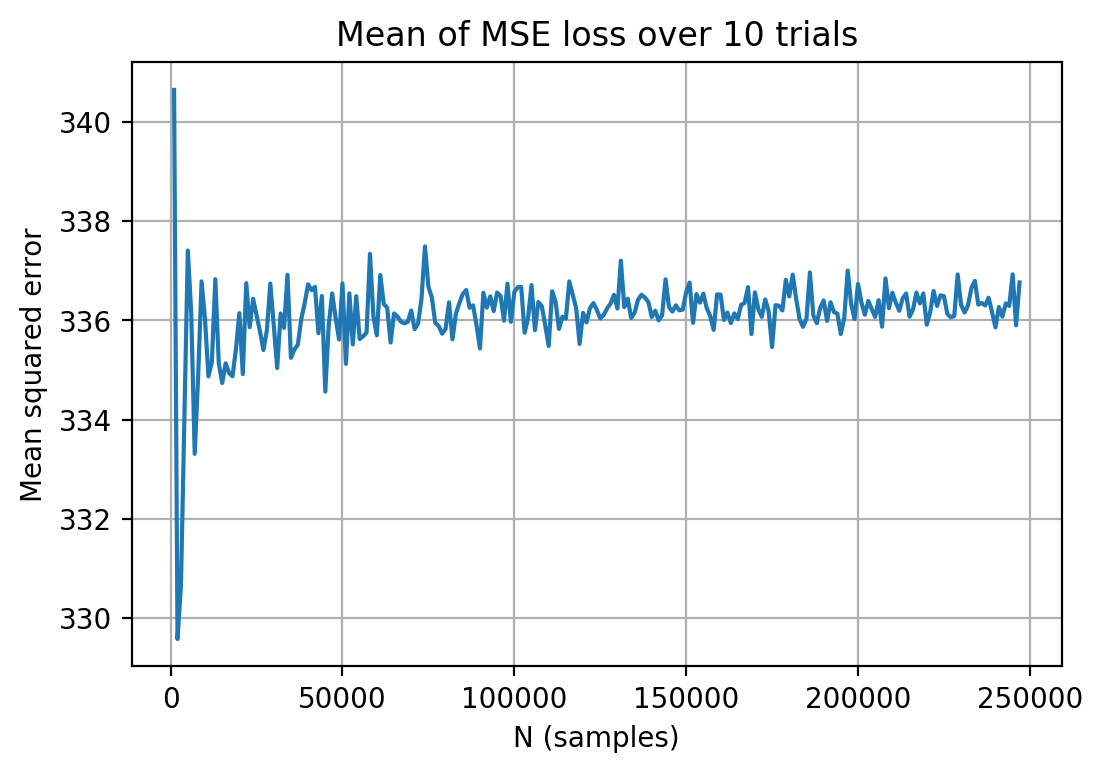

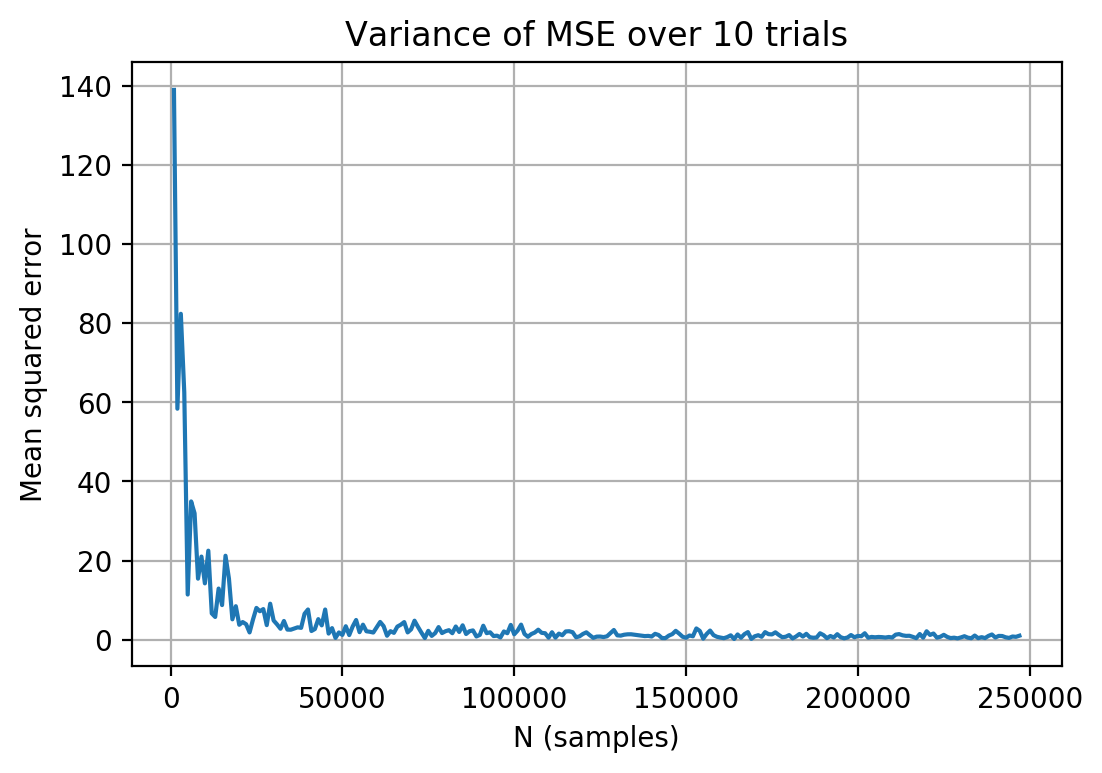

In [241]:
N = np.arange(1000, x_train_reg.shape[0], 1000)

mean_mse_by_N = []
var_mse_by_N = []

for n in N:
    
    runs = 10
    runs_mse = []
    # run on 10 different random subsets
    for r in np.arange(runs):
        runs_mse.append(train_lin_reg_model(n))
        
    mean_mse_by_N.append(np.mean(runs_mse))
    var_mse_by_N.append(np.var(runs_mse))
    
plt.plot(N, mean_mse_by_N)
plt.title('Mean of MSE loss over 10 trials')
plt.ylabel('Mean squared error')
plt.xlabel('N (samples)')
plt.grid()
plt.show()

plt.plot(N, var_mse_by_N)
plt.title('Variance of MSE over 10 trials')
plt.ylabel('Mean squared error')
plt.xlabel('N (samples)')
plt.grid()
plt.show()

2. Plot the cpu-time as a function of N.

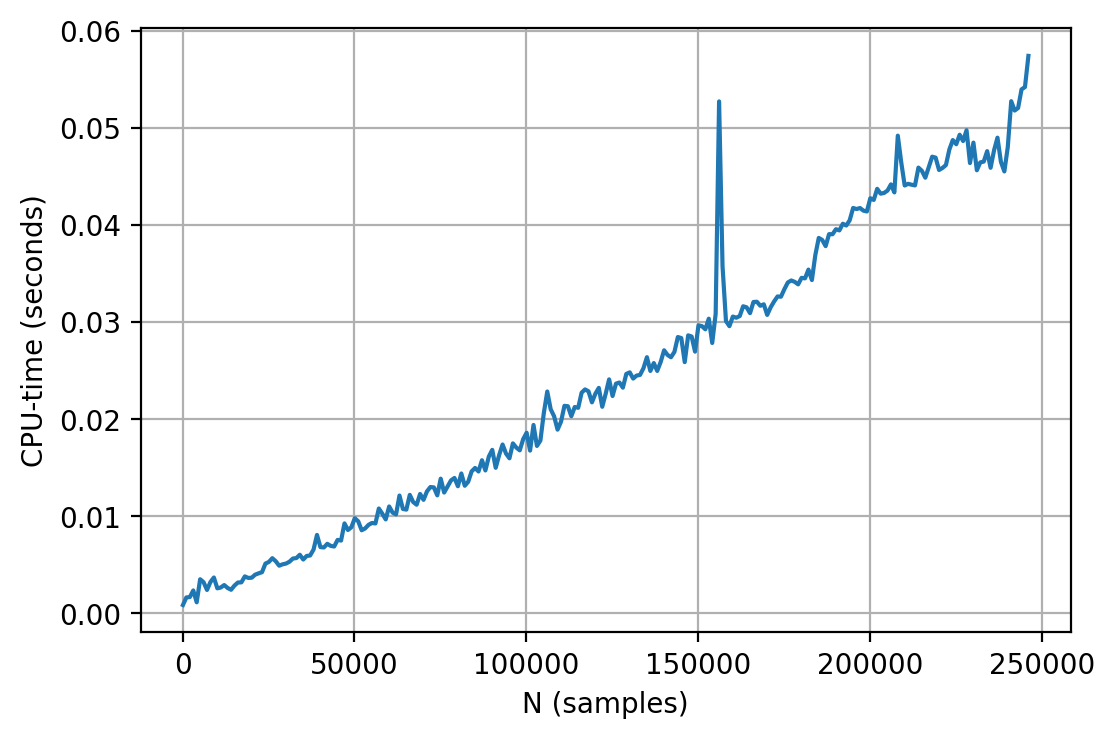

In [196]:
N = np.arange(100, x_train_reg.shape[0], 1000)
time_by_N = []

for n in N:
    start = time.time()
    train_lin_reg_model(n)
    end = time.time()
    elapsed = end - start
    time_by_N.append(elapsed)
    
plt.plot(N, time_by_N)
plt.ylabel('CPU-time (seconds)')
plt.xlabel('N (samples)')
plt.grid()
plt.show()

3. Explain in detail the behaviour of both curves: what is the trend you observe? does it stabilize? why?

## Effect of N

### Performance
Is is clear that when the number of training examples, N, is very small the MSE tends to be lower but the variance among different subsets of the data is very high. This effect quickly goes away as N increases, and after around 10,000 samples the variance begins to tend toward 0. As we pass beyond 100,000 samples the inter-trial variance of the MSE is nearly zero, meaning that regardless of what subset of the data we have selected, the MSE of the trained model is largely the same. We can also notice that we increase N the average MSE value across trials begins to converge to a non-zero constant. In this case, as we add more data we do not see a significant improvement in the performance of the model. This indicates that the underlying data generation process is more complex than our linear model can represent. 

### CPU-Time
Our method of measuring compute time is very crude so other processes can effect the results, but nevertheless there is a clear linear trend as we increase N. We also note that training time is quite fast for a single run, at about 10ms for a model with 50,000 samples. Even training on the entire dataset takes only 55ms. Take note of this as the results are quite different for the logistic regression case. 

### Overall
This regression task is fairly challenging since there are many external factors that influence the popularity of a track and there may be little relevant information in the provided features that will help predict the exact popualarity value of the song in question. For our MSE value of about 350, that translates to $\sqrt{350}=18.7$ error in popularity value on average, which isn't all that bad.

4. Explore how the learned weights change as a function of N. For this, you can make separate stem plots for several values of N. Can you find an interpretation for the learned weights?

# Classification Task

Choose a classification dataset and apply logistic regression. Repeat the previous four steps using as error the mean accuracy.


In [257]:
# contruct feature vectors
x_train_log_reg = train.iloc[:,3:10].to_numpy()

# construct labels
y_train_log_reg = train.iloc[:,12].to_numpy()

print(x_train_log_reg.shape, y_train_log_reg.shape)

(247035, 7) (247035,)


In [258]:
# separate minority and majority classes
unpopular = x_train_log_reg[y_train_log_reg==0]
popular = x_train_log_reg[y_train_log_reg==1]

# upsample minority
popular_upsampled = resample(popular,
                            replace=True, # sample with replacement
                            n_samples=len(unpopular), # match number in majority class
                            random_state=27) # reproducible results

x_train_log_reg = np.concatenate([unpopular, popular_upsampled])
y_train_log_reg = np.concatenate([np.zeros(len(unpopular)), np.ones(len(popular_upsampled))])

In [259]:
def train_log_reg_model(N):
    
    logreg = LogisticRegression(C=1e5, solver='lbfgs', max_iter=10000)

    rand_idx = np.random.randint(0, x_train_log_reg.shape[0], N)
    
    x_train_subset = x_train_log_reg[rand_idx]
    y_train_subset = y_train_log_reg[rand_idx]
    
    logreg.fit(x_train_subset, y_train_subset)
    
    acc = logreg.score(x_train_subset, y_train_subset)
    
    return acc

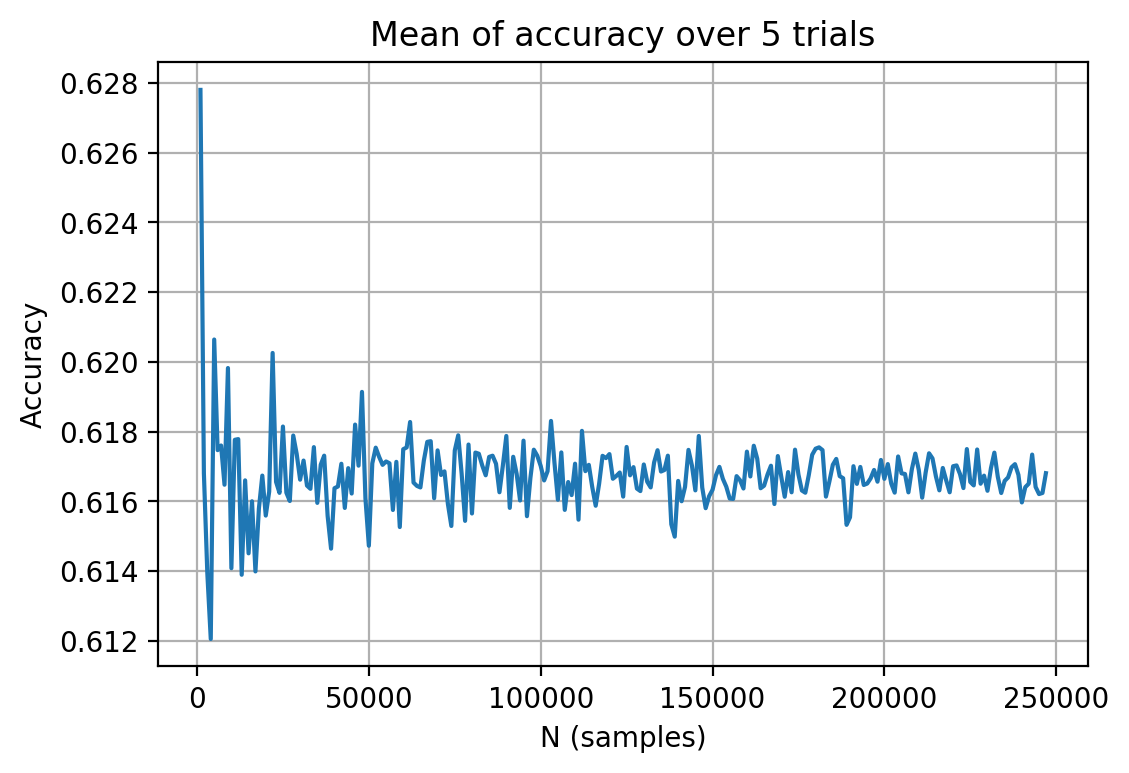

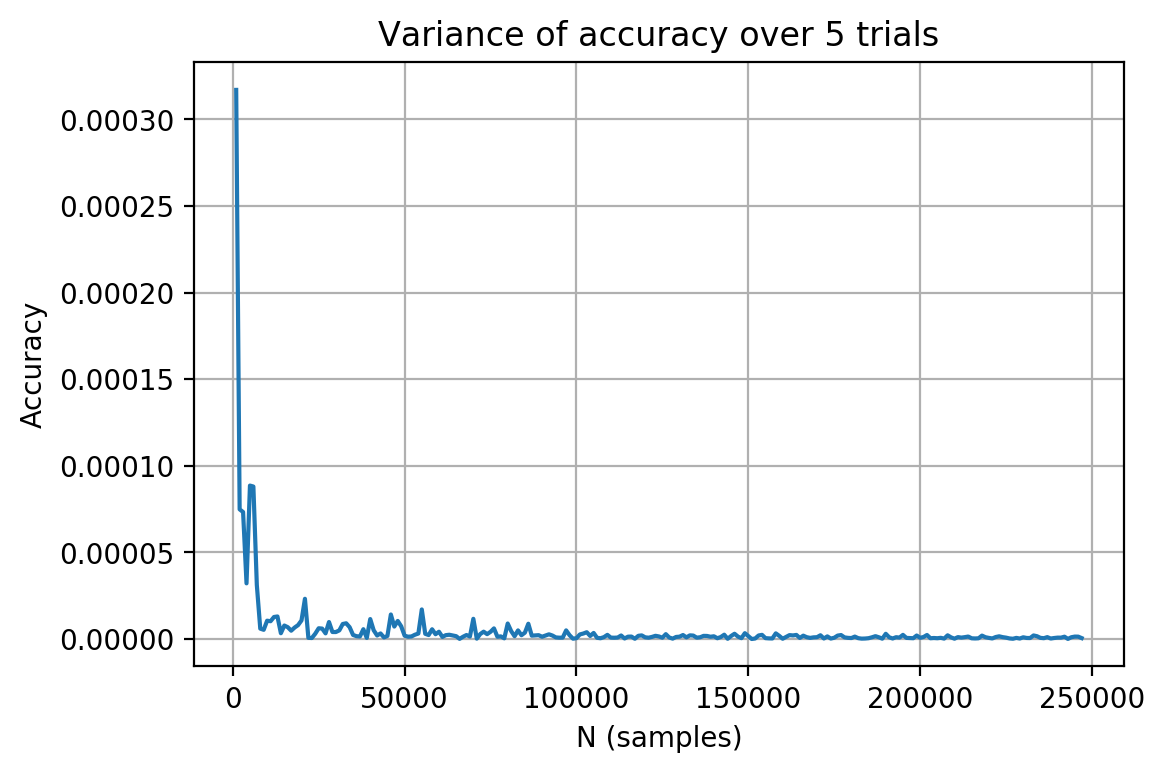

In [260]:
N = np.arange(1000, x_train_log_reg.shape[0], 1000)
mean_acc_by_N = []
var_acc_by_N = []

for n in N:
    
    runs = 5
    runs_acc = []
    # run on 5 different random subsets
    for r in np.arange(runs):
        runs_acc.append(train_log_reg_model(n))
        
    mean_acc_by_N.append(np.mean(runs_acc))
    var_acc_by_N.append(np.var(runs_acc))

plt.plot(N, mean_acc_by_N)
plt.title('Mean of accuracy over 5 trials')
plt.ylabel('Accuracy')
plt.xlabel('N (samples)')
plt.grid()
plt.show()

plt.plot(N, var_acc_by_N)
plt.title('Variance of accuracy over 5 trials')
plt.ylabel('Accuracy')
plt.xlabel('N (samples)')
plt.grid()
plt.show()

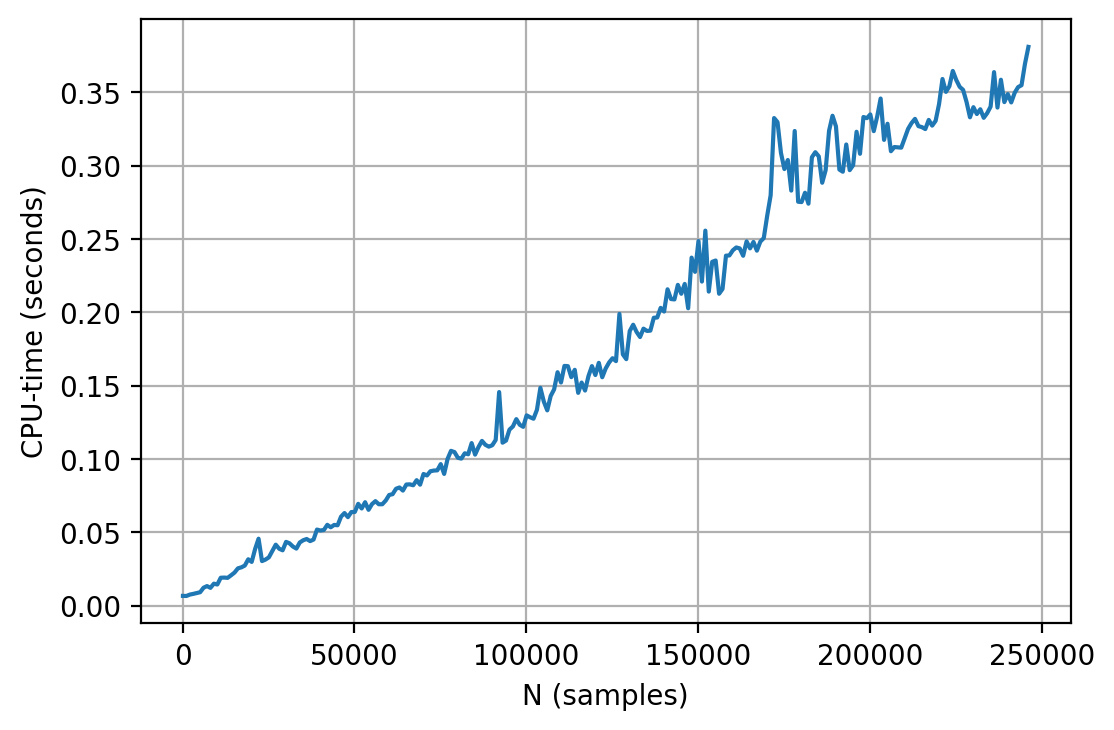

In [200]:
N = np.arange(100, x_train_log_reg.shape[0], 1000)
time_by_N = []

for n in N:
    start = time.time()
    train_log_reg_model(n)
    end = time.time()
    elapsed = end - start
    time_by_N.append(elapsed)
    
plt.plot(N, time_by_N)
plt.ylabel('CPU-time (seconds)')
plt.xlabel('N (samples)')
plt.grid()
plt.show()

## Effect of N

### Performance
Things are very similar to the linear regression case. At the start, with small N, the variance of the accuracy is very high, with lower mean accuracy. This quickly goes away as we increase N to a reasonable size. Things stabilize and the varience tends towards zero as we increase N. This seems obvious though, since when N is very large it is very close to the size of the complete dataset. This means that no matter how we sample N samples from the dataset, the dataset will contain mostly the same samples. Even so, at as few as 50,000 samples (1/5 of the full dataset) the variance is nearly 0 across trials. 

### CPU-Time
Again we see a clear linear trend in the time-complexity as N increases. The biggest difference here is that a single run of the model training is much more costly than the linear regression case. For example, training with around 50,000 samples takes nearly 60ms, or 6 times more. 

### Overall
We should also observe the confusion matrix, since I believe there are far fewer examples of popular songs compared to unpopular songs, which can cause bias in our classifier. For example, the model may learn to simply always classify the input as unpopular, and since 80% of the samples are unpopular we achieve a seemingly good model. It turns out this is true. See the confusion matrix below. We attempt to handle the class imblance by adding in copies of the positive class for balance. This helps, as can be shown in the second confusion matrix, but we still don't do great with about 60% accuracy.  

In [249]:
# this code comes from sklearn example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Class Imbalance

Confusion matrix, without normalization
[[217354      0]
 [ 29681      0]]


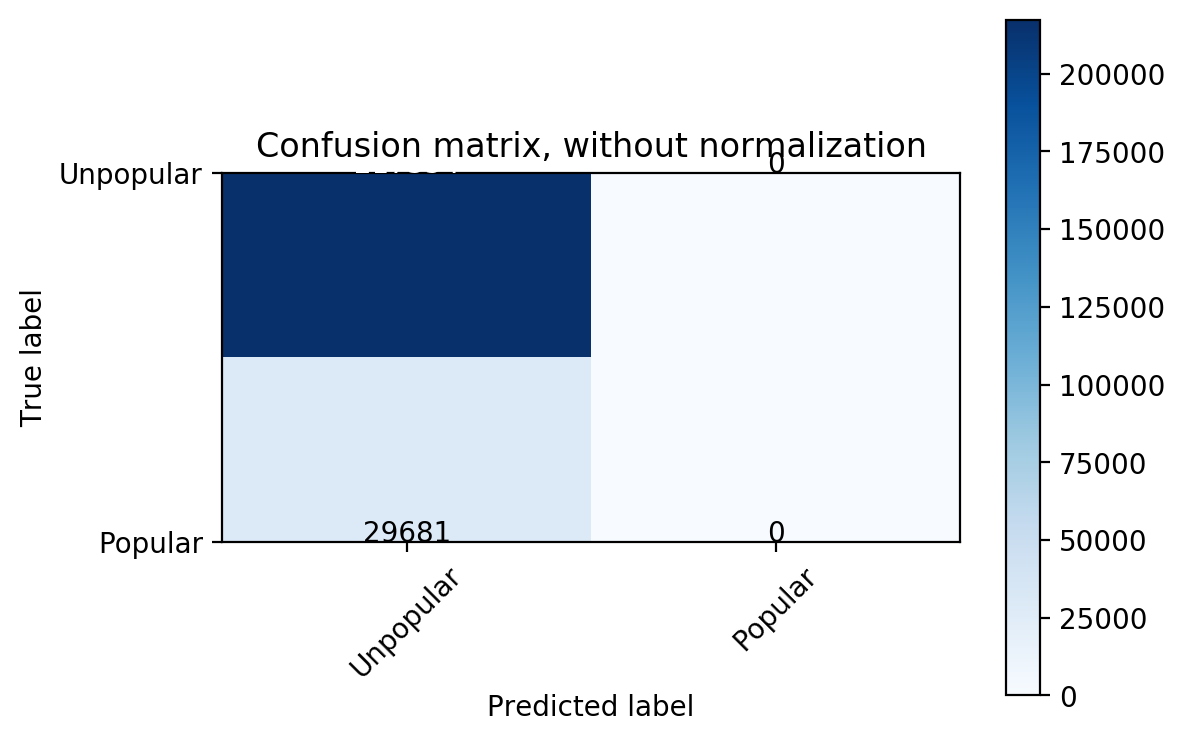

In [250]:
# Train model with the complete dataset
logreg = LogisticRegression(C=1e5, solver='lbfgs', max_iter=10000)
logreg.fit(x_train_log_reg, y_train_log_reg)
y_pred_log_reg = logreg.predict(x_train_log_reg)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train_log_reg, y_pred_log_reg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Unpopular','Popular'],
                      title='Confusion matrix, without normalization')
plt.show()

## Try resampling to address imbalance

Confusion matrix, without normalization
[[106328 111026]
 [ 55612 161742]]


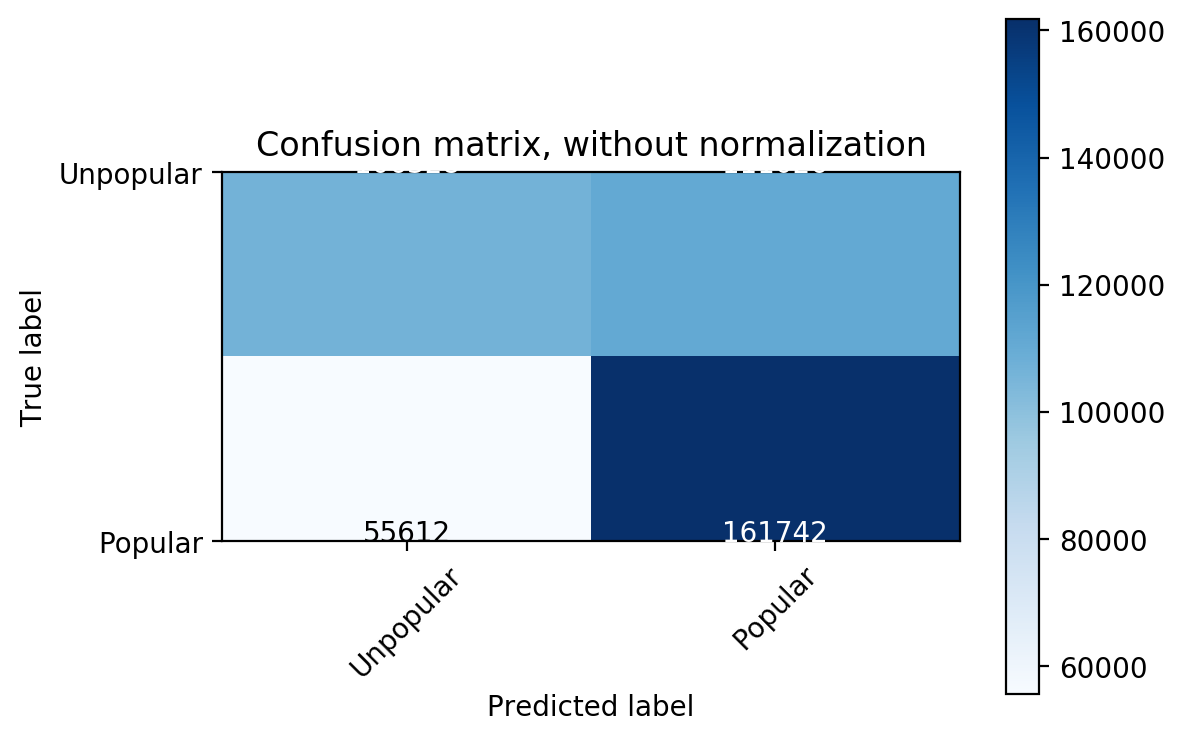

In [256]:
# separate minority and majority classes
unpopular = x_train_log_reg[y_train_log_reg==0]
popular = x_train_log_reg[y_train_log_reg==1]

# upsample minority
popular_upsampled = resample(popular,
                            replace=True, # sample with replacement
                            n_samples=len(unpopular), # match number in majority class
                            random_state=27) # reproducible results

x_train_log_reg_upsampled = np.concatenate([unpopular, popular_upsampled])
y_train_log_reg_upsampled = np.concatenate([np.zeros(len(unpopular)), np.ones(len(popular_upsampled))])

# Train model with the complete dataset
logreg = LogisticRegression(C=1e5, solver='lbfgs', max_iter=10000)
logreg.fit(x_train_log_reg_upsampled, y_train_log_reg_upsampled)
y_pred_log_reg = logreg.predict(x_train_log_reg_upsampled)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train_log_reg_upsampled, y_pred_log_reg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Unpopular','Popular'],
                      title='Confusion matrix, without normalization')
plt.show()

# Remarks
- Feel free to use your favourite software. We recommend Python.
- You can obtain smoother curves by averaging over several permutations of
the dataset. Ideally you could also plot the variance, not only the mean.
- Check that your results are in agreement with the theory.
- Submit the report (pdf) with the answers and the code separately.
- Useful links:
    - http://scikit-learn.org/stable/user_guide.html 
    - http://jupyter.org/ 
    - https://twitter.com/zacharylipton/status/1167298276686589953lang=en
